# GMF — Task 5: Strategy Backtesting (Aug 1, 2024 → Jul 31, 2025)

**Offline-first, Colab-ready.**  
This notebook:
- Loads TSLA/BND/SPY prices from Drive (**no live downloads**).
- Loads your **strategy weights** from Task 4 (prefers *Max Sharpe* → falls back to *Min Vol* → JSON).
- Backtests over **2024-08-01 to 2025-07-31**, comparing against a **60% SPY / 40% BND** benchmark.
- Supports **hold (no rebalance)** and **monthly rebalance** modes.
- Outputs plots, CSV, and a metrics JSON (final return, annualized vol, Sharpe).


In [1]:
# === 1) Pin a clean stack and HARD RESTART (run this cell ALONE first) ===
%pip install -q --force-reinstall   numpy==1.26.4   pandas==2.2.2   matplotlib==3.9.0

import IPython
IPython.Application.instance().kernel.do_shutdown(True)  # Colab will restart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509

{'status': 'ok', 'restart': True}

In [2]:
# === 2) Mount Drive & set paths ===
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['GMF_DRIVE_PROJECT_DIR'] = '/content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization'

BASE_DIR   = os.environ['GMF_DRIVE_PROJECT_DIR']
DATA_DIR   = os.path.join(BASE_DIR, 'data')
OUT_PLOTS  = os.path.join(BASE_DIR, 'outputs', 'plots')
OUT_METRICS= os.path.join(BASE_DIR, 'outputs', 'metrics')
for d in [DATA_DIR, OUT_PLOTS, OUT_METRICS]:
    os.makedirs(d, exist_ok=True)

print('BASE_DIR:', BASE_DIR)
print('DATA_DIR contents:', os.listdir(DATA_DIR))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization
DATA_DIR contents: ['TSLA_1d.csv', 'BND_1d.csv', 'SPY_1d.csv', 'returns_daily.csv', 'prices_adj_close.csv']


In [5]:
# === 3) Load prices (robust), clean to business days, restrict backtest window ===
import pandas as pd, numpy as np, os

TICKERS = ['TSLA','BND','SPY']
START_BT = pd.Timestamp('2024-08-01')
END_BT   = pd.Timestamp('2025-07-31')

combined_path = os.path.join(DATA_DIR, 'prices_adj_close.csv')

def _read_combined_prices(path: str) -> pd.DataFrame:
    """Robust reader: handles stray header rows, wrong index, and commas in numbers."""
    if not os.path.exists(path):
        raise FileNotFoundError("Missing data/prices_adj_close.csv — run earlier tasks to build it.")

    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    # If a 'Date' column exists, use it; otherwise use the first column as dates
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date']).set_index('Date')
    else:
        idxcol = df.columns[0]
        df[idxcol] = pd.to_datetime(df[idxcol], errors='coerce')
        df = df.dropna(subset=[idxcol]).set_index(idxcol)

    # Keep only the tickers we care about, if present
    keep = [c for c in df.columns if c in TICKERS]
    if not keep:
        raise ValueError(f"Combined CSV does not contain {TICKERS}. Found columns: {list(df.columns)}")

    # Clean numeric (handle '1,234.56' etc.), ffill, drop any all-NaN rows
    out = df[keep].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(',', ''), errors='coerce'))
    out = out.ffill().dropna(how='any')
    # Deduplicate dates and sort
    out = out[~out.index.duplicated(keep='last')].sort_index()
    return out

def _rebuild_from_per_ticker() -> pd.DataFrame:
    """If combined is malformed, rebuild from per-ticker CSVs in data/."""
    def load_adj_close(csv_path: str) -> pd.Series:
        df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
        col = next((c for c in ['Adj Close','AdjClose','Adj_Close','Adjclose'] if c in df.columns), None)
        if col is None:
            raise ValueError(f"'Adj Close' not in {csv_path}. Columns: {list(df.columns)}")
        s = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
        s.name = os.path.basename(csv_path).split('_')[0]
        s.index = pd.to_datetime(s.index, errors='coerce')
        s = s.dropna().sort_index()
        return s

    missing = [tk for tk in TICKERS if not os.path.exists(os.path.join(DATA_DIR, f'{tk}_1d.csv'))]
    if missing:
        raise FileNotFoundError(f"Missing per-ticker files {missing}. Recreate via Task 1/2 notebooks.")

    adj = [load_adj_close(os.path.join(DATA_DIR, f'{tk}_1d.csv')) for tk in TICKERS]
    prices = pd.concat(adj, axis=1).sort_index().ffill().dropna(how='any')
    prices.to_csv(combined_path)
    print('Rebuilt combined prices →', combined_path)
    return prices

# Try robust read; if columns/timestamps are wrong, rebuild from per-ticker CSVs
try:
    prices = _read_combined_prices(combined_path)
    # sanity check required tickers
    if any(tk not in prices.columns for tk in TICKERS):
        raise ValueError("Combined file missing required tickers, rebuilding…")
except Exception as e:
    print("[warn] Combined CSV malformed:", e, "→ rebuilding from per-ticker CSVs …")
    prices = _rebuild_from_per_ticker()

# Keep desired tickers
prices = prices[TICKERS].copy()

# Business-day index & forward fill
bd = pd.bdate_range(prices.index.min(), prices.index.max(), freq='B')
prices = prices.reindex(bd).ffill()
prices.index.name = 'Date'

# Restrict to backtest window (pad one B-day for return calculation)
win = prices.loc[(prices.index >= START_BT - pd.tseries.offsets.BDay(1)) & (prices.index <= END_BT)].copy()
rets = win.pct_change().dropna()  # daily simple returns
prices_win = prices.loc[(prices.index >= START_BT) & (prices.index <= END_BT)].copy()

print("Backtest window:", rets.index.min().date(), "→", rets.index.max().date(), f"(n={len(rets)})")
display(prices_win.head(), rets.head())


Backtest window: 2024-08-01 → 2025-07-30 (n=260)


,TSLA,BND,SPY
Date,,,
2024-08-01,216.860001,70.832077,536.329895
2024-08-02,207.669998,71.640816,526.344360
2024-08-05,198.880005,71.573418,511.015259
2024-08-06,200.639999,71.130531,515.726562
2024-08-07,191.759995,70.957237,512.279419


,TSLA,BND,SPY
Date,,,
2024-08-01,-0.065541,0.003738,-0.014161
2024-08-02,-0.042378,0.011418,-0.018618
2024-08-05,-0.042327,-0.000941,-0.029124
2024-08-06,0.008850,-0.006188,0.009219
2024-08-07,-0.044258,-0.002436,-0.006684


In [7]:
# === 4) Load strategy weights from Task 4 outputs (robust) ===
import pandas as pd, numpy as np, os, json

TICKERS = ['TSLA','BND','SPY']  # ensure these match your pipeline

def _read_weights_csv(path: str) -> pd.Series:
    df = pd.read_csv(path)
    cols_lower = [c.strip().lower() for c in df.columns]
    df.columns = [c.strip() for c in df.columns]

    # Heuristic: if first column *looks* like tickers, make it the index
    first = df.columns[0]
    if df[first].astype(str).isin(TICKERS).sum() >= 2:
        df = df.set_index(first)

    # Try to find the weights column
    cand_names = ['weight', 'weights', 'value', 'allocation']
    weight_col = None
    for name in cand_names:
        if name in cols_lower:
            weight_col = df.columns[cols_lower.index(name)]
            break
    if weight_col is None:
        # pick the 1st numeric-looking column (max numeric count)
        numeric_counts = {}
        for c in df.columns:
            try:
                numeric_counts[c] = pd.to_numeric(df[c], errors='coerce').notna().sum()
            except Exception:
                numeric_counts[c] = -1
        weight_col = max(numeric_counts, key=numeric_counts.get)

    s = pd.to_numeric(df[weight_col], errors='coerce').fillna(0.0)
    s.index = [str(i).strip().upper() for i in df.index]  # uppercase tickers
    return s

def load_strategy_weights():
    p1 = os.path.join(OUT_METRICS, "task4_weights_max_sharpe.csv")
    p2 = os.path.join(OUT_METRICS, "task4_weights_min_vol.csv")
    p3 = os.path.join(OUT_METRICS, "task4_portfolio_summary.json")

    w = None
    if os.path.exists(p1):
        try:
            w = _read_weights_csv(p1)
            print("Loaded weights from", p1, "| sum(raw) =", w.sum())
        except Exception as e:
            print("[warn] Could not read", p1, ":", e)

    if (w is None or w.sum() == 0.0) and os.path.exists(p2):
        try:
            w = _read_weights_csv(p2)
            print("Loaded weights from", p2, "| sum(raw) =", w.sum())
        except Exception as e:
            print("[warn] Could not read", p2, ":", e)

    if (w is None or w.sum() == 0.0) and os.path.exists(p3):
        try:
            with open(p3, "r") as f:
                summ = json.load(f)
            if "max_sharpe" in summ and "weights" in summ["max_sharpe"]:
                w = pd.Series(summ["max_sharpe"]["weights"])
                print("Loaded weights from JSON (max_sharpe).")
            elif "min_volatility" in summ and "weights" in summ["min_volatility"]:
                w = pd.Series(summ["min_volatility"]["weights"])
                print("Loaded weights from JSON (min_volatility).")
            else:
                raise ValueError("No weights found in summary JSON.")
            # Coerce numeric
            w = pd.to_numeric(w, errors='coerce').fillna(0.0)
            w.index = [str(i).strip().upper() for i in w.index]
        except Exception as e:
            print("[warn] Could not read", p3, ":", e)

    if w is None:
        raise FileNotFoundError("No Task 4 weights found/readable. Ensure Task 4 saved outputs to OUT_METRICS.")

    # Align to our tickers and renormalize
    w = w.reindex(TICKERS).fillna(0.0).astype(float)
    ssum = w.sum()
    if ssum <= 0:
        # Last resort: equal-weight the available tickers so backtest can proceed
        print("[warn] Weights sum to zero after alignment. Falling back to equal weights.")
        w = pd.Series(1.0/len(TICKERS), index=TICKERS)

    return w / w.sum()

w_strategy = load_strategy_weights()
display(w_strategy.to_frame("weight"))


[warn] Could not read /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/task4_weights_max_sharpe.csv : index 1 is out of bounds for axis 0 with size 1
[warn] Could not read /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/task4_weights_min_vol.csv : index 1 is out of bounds for axis 0 with size 1
Loaded weights from JSON (max_sharpe).
[warn] Weights sum to zero after alignment. Falling back to equal weights.


,weight
TSLA,0.333333
BND,0.333333
SPY,0.333333


In [8]:
# === 5) Backtesting helpers (hold vs monthly rebalance) ===
import pandas as pd, numpy as np

def backtest_hold(prices: pd.DataFrame, weights: pd.Series, start_val: float = 1.0) -> pd.Series:
    """Buy-and-hold: allocate by weights on day 0, then let drift; no rebalancing."""
    w = weights.reindex(prices.columns).values
    # initial allocation into units
    start_prices = prices.iloc[0].values
    units = (start_val * w) / start_prices
    # daily portfolio value from units * prices
    port_vals = (prices.values * units).sum(axis=1)
    return pd.Series(port_vals / start_val, index=prices.index, name="Strategy_Hold")

def backtest_monthly_rebalance(rets: pd.DataFrame, weights: pd.Series, start_val: float = 1.0) -> pd.Series:
    """Monthly rebalancing at month start (using previous close)."""
    w = weights.reindex(rets.columns).fillna(0.0).values
    equity = start_val
    curve = []
    prev_month = None
    alloc = w.copy()  # target weights, applied daily

    for dt, r in rets.iterrows():
        # If it's the first day of a month, reset allocation to target weights
        if prev_month is None or dt.month != prev_month:
            alloc = w.copy()
        # Apply daily return to equity
        equity *= (1.0 + float((r.values * alloc).sum()))
        curve.append((dt, equity))
        prev_month = dt.month

    out = pd.Series([v for _, v in curve], index=[d for d, _ in curve], name="Strategy_Monthly")
    return out / start_val

def compute_perf(port_curve: pd.Series) -> dict:
    daily = port_curve.pct_change().dropna()
    ann_return = (port_curve.iloc[-1] / port_curve.iloc[0]) - 1.0
    ann_vol    = daily.std() * (252 ** 0.5)
    sharpe     = (daily.mean() * 252) / ann_vol if ann_vol > 0 else float("nan")
    return {"final_return": float(ann_return), "ann_vol": float(ann_vol), "sharpe": float(sharpe)}

In [9]:
# === 6) Run backtests and 60/40 benchmark ===
import pandas as pd, numpy as np

# Strategy curves
curve_hold  = backtest_hold(prices_win, w_strategy, start_val=1.0)
curve_month = backtest_monthly_rebalance(rets.loc[curve_hold.index], w_strategy, start_val=1.0)

# Benchmark: 60% SPY / 40% BND (hold)
w_bench = pd.Series({"TSLA": 0.0, "SPY": 0.6, "BND": 0.4})
curve_bench = backtest_hold(prices_win[["SPY","BND"]].join(prices_win["TSLA"]), w_bench, start_val=1.0)

# Align indices
common_idx = curve_hold.index.intersection(curve_month.index).intersection(curve_bench.index)
curve_hold, curve_month, curve_bench = curve_hold.loc[common_idx], curve_month.loc[common_idx], curve_bench.loc[common_idx]

perf_hold  = compute_perf(curve_hold)
perf_month = compute_perf(curve_month)
perf_bench = compute_perf(curve_bench)

print("Performance — HOLD:", perf_hold)
print("Performance — MONTHLY:", perf_month)
print("Performance — BENCH 60/40:", perf_bench)

Performance — HOLD: {'final_return': 0.22800615886317366, 'ann_vol': 0.3169210262006338, 'sharpe': 0.7874713790330776}
Performance — MONTHLY: {'final_return': 0.27726179748503954, 'ann_vol': 0.2848123982200804, 'sharpe': 0.9767601699887215}
Performance — BENCH 60/40: {'final_return': 0.12172874817616619, 'ann_vol': 0.12150398723323233, 'sharpe': 0.9802563106611507}


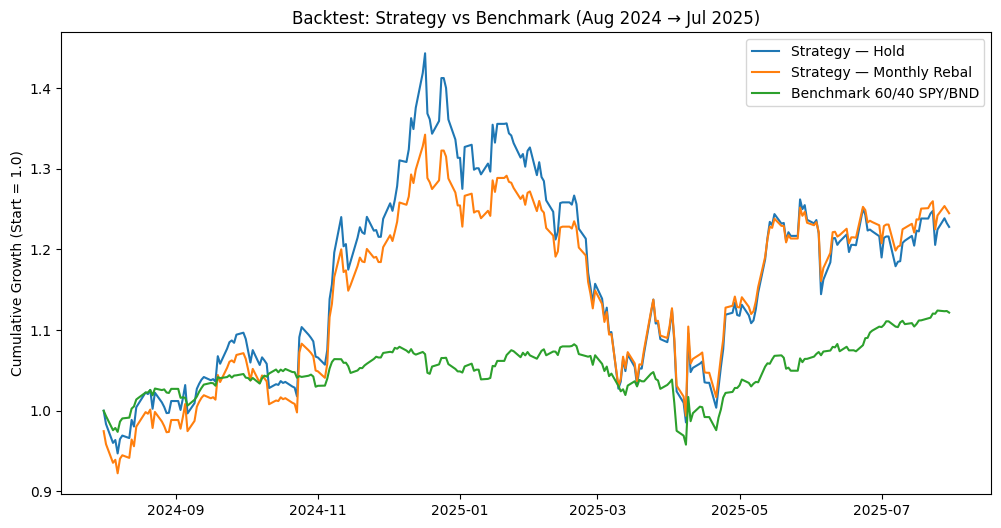

Saved plot → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/plots/task5_backtest_curves.png
Saved curves CSV → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/task5_backtest_curves.csv
Saved metrics JSON → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/task5_backtest_metrics.json


In [10]:
# === 7) Plot curves and save outputs ===
import matplotlib.pyplot as plt
import os, json
import pandas as pd

plt.figure(figsize=(12,6))
plt.plot(curve_hold.index, curve_hold.values, label="Strategy — Hold")
plt.plot(curve_month.index, curve_month.values, label="Strategy — Monthly Rebal")
plt.plot(curve_bench.index, curve_bench.values, label="Benchmark 60/40 SPY/BND")
plt.title("Backtest: Strategy vs Benchmark (Aug 2024 → Jul 2025)")
plt.ylabel("Cumulative Growth (Start = 1.0)")
plt.legend()
plot_path = os.path.join(OUT_PLOTS, "task5_backtest_curves.png")
plt.savefig(plot_path)
plt.show()
print("Saved plot →", plot_path)

# Save curves CSV
curves_df = pd.concat([curve_hold, curve_month, curve_bench], axis=1)
curves_path = os.path.join(OUT_METRICS, "task5_backtest_curves.csv")
curves_df.to_csv(curves_path)
print("Saved curves CSV →", curves_path)

# Save metrics JSON
metrics = {
    "strategy_hold": perf_hold,
    "strategy_monthly": perf_month,
    "benchmark_60_40": perf_bench,
    "window": ["2024-08-01", "2025-07-31"]
}
metrics_path = os.path.join(OUT_METRICS, "task5_backtest_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics JSON →", metrics_path)

### Notes & Next Steps
- **Rebalancing:** The hold curve is pure buy-and-hold. The monthly curve rebalances on the first trading day of each month.
- **Sharpe:** Uses daily mean/std with 252 scaling and RF=0; adjust if needed.
- **Extensions:** Add transaction costs, slippage, and a rolling **forecast→reoptimize** loop.
- **Benchmark:** Static 60/40 SPY/BND; you can add a monthly-rebalanced version as a second benchmark if desired.
